<a href="https://colab.research.google.com/github/oochuru/MLBootCamp25Ochuru/blob/main/9_MLBootcamp_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Bootcamp 2025

### Final Project: Train a Deep Learning model to identify Grocery item

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import os
import csv
from datetime import datetime

In [3]:
# NOTE: Create directory 'Datasets/GroceryStoreDataset', unzip the shared dataset in it and mount the Google Drive
# The original dataset used is: https://www.kaggle.com/datasets/validmodel/grocery-store-dataset?resource=download and it has been reduced further for our use-case
data_dir = '/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset'  # Mount dataset in Google Drive

In [4]:
!unzip '/content/drive/MyDrive/archive.zip' -d '/content/drive/MyDrive/archive_unzipped/'

print(os.listdir('/content/drive/MyDrive/archive_unzipped'))



Archive:  /content/drive/MyDrive/archive.zip
replace /content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/classes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ['GroceryStoreDataset']


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [7]:
def extract_class_names(csv_file_path):
    """
    Extracts class names from a CSV file and returns them as a list.

    Args:
        csv_file_path (str): The path to the CSV file.

    Returns:
        tuple: A tuple containing a list of class names and the number of classes.
               Returns (None, 0) if the file does not exist or an error occurs.
    """
    try:
        with open(csv_file_path, 'r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header row if it exists
            class_names = [row[2] for row in reader]  # Assuming class names are in the first column
            class_names = sorted(set(class_names))
        return class_names, len(class_names)

    except FileNotFoundError:
        print(f"Error: File '{csv_file_path}' not found.")
        return None, 0
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, 0

In [8]:
# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
# Identify that all folders are accessible from mounted Google Drive
for x in ['train', 'test']:
  path_new = os.path.join(data_dir, x)
  print(path_new)
  for folder in os.listdir(path_new):
    folder_path = os.path.join(path_new, folder)
    print(folder_path)


/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/train
/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/train/Apple
/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/train/Avocado
/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/train/Banana
/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/train/Kiwi
/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/train/Lemon
/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/train/Lime
/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/train/Mango
/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/train/Melon
/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/train/Nectarine
/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/train/Orange
/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/train/Papaya
/content/drive/MyDrive/archive_unzipped

In [10]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}  # Assuming you have train and test folders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

print(f"Dataset sizes: {dataset_sizes}")

Dataset sizes: {'train': 2640, 'test': 2485}


In [11]:
class_names = image_datasets['train'].classes

print(class_names)
print(len(class_names))

class_names = image_datasets['train'].classes


print(class_names)
print(len(class_names))


num_classes = len(class_names)

['Apple', 'Asparagus', 'Aubergine', 'Avocado', 'Banana', 'Brown-Cap-Mushroom', 'Cabbage', 'Carrots', 'Cucumber', 'Garlic', 'Ginger', 'Juice', 'Kiwi', 'Leek', 'Lemon', 'Lime', 'Mango', 'Melon', 'Milk', 'Nectarine', 'Oat-Milk', 'Oatghurt', 'Onion', 'Orange', 'Papaya', 'Passion-Fruit', 'Peach', 'Pear', 'Pepper', 'Pineapple', 'Plum', 'Pomegranate', 'Potato', 'Red-Beet', 'Red-Grapefruit', 'Satsumas', 'Sour-Cream', 'Sour-Milk', 'Soy-Milk', 'Soyghurt', 'Tomato', 'Yoghurt', 'Zucchini']
43
['Apple', 'Asparagus', 'Aubergine', 'Avocado', 'Banana', 'Brown-Cap-Mushroom', 'Cabbage', 'Carrots', 'Cucumber', 'Garlic', 'Ginger', 'Juice', 'Kiwi', 'Leek', 'Lemon', 'Lime', 'Mango', 'Melon', 'Milk', 'Nectarine', 'Oat-Milk', 'Oatghurt', 'Onion', 'Orange', 'Papaya', 'Passion-Fruit', 'Peach', 'Pear', 'Pepper', 'Pineapple', 'Plum', 'Pomegranate', 'Potato', 'Red-Beet', 'Red-Grapefruit', 'Satsumas', 'Sour-Cream', 'Sour-Milk', 'Soy-Milk', 'Soyghurt', 'Tomato', 'Yoghurt', 'Zucchini']
43


In [12]:
# Load pre-trained EfficientNetB4
model = models.efficientnet_b4(pretrained=True)

# Modify the classifier
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def predict_image(image_path, model, class_names):
  img = Image.open(image_path).convert('RGB')
  img_t = data_transforms['train'](img).unsqueeze(0)
  img_t = img_t.to(device)
  model.eval()
  with torch.no_grad():
    out = model(img_t)
    _, index = torch.max(out, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    print(f"Predicted Class: {class_names[index[0]]}, Confidence: {percentage[index[0]].item():.2f}%")

In [14]:
def train_model(model, criterion, optimizer, num_epochs=25):
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        now = datetime.now()
        print(now.strftime("%Y-%m-%d %H:%M:%S"))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            i = 0
            for inputs, labels in dataloaders[phase]:
                i += 1
                if i % 10 == 0:
                    print(f"Batch {i} of {len(dataloaders[phase])}")
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

    return model, history

In [15]:
base_path = '/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset'
for root, dirs, files in os.walk(base_path):
    print(f"\n📁 Folder: {root}")
    for name in files[:5]:  # Print first 5 files per folder to preview
        print(f"   - {name}")


📁 Folder: /content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset
   - test.txt
   - classes.csv
   - train.txt
   - val.txt

📁 Folder: /content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/iconic-images-and-descriptions

📁 Folder: /content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/iconic-images-and-descriptions/Fruit

📁 Folder: /content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/iconic-images-and-descriptions/Fruit/Apple

📁 Folder: /content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/iconic-images-and-descriptions/Fruit/Apple/Golden-Delicious
   - Golden-Delicious_Information.txt
   - Golden-Delicious_Iconic.jpg
   - Golden-Delicious_Description.txt

📁 Folder: /content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/iconic-images-and-descriptions/Fruit/Apple/Granny-Smith
   - Granny-Smith_Information.txt
   - Granny-Smith_Description.txt
   - Granny-Smith_Iconic.jpg

📁 Folder: /content/drive/MyDrive/

In [16]:
# Before training
predict_image('/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/train/Mango/Mango_002.jpg', model, class_names)
predict_image('/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/val/Pineapple/Pineapple_002.jpg', model, class_names)


Predicted Class: Garlic, Confidence: 2.63%
Predicted Class: Leek, Confidence: 2.59%


In [ ]:
model, history = train_model(model, criterion, optimizer, num_epochs=5)


Epoch 0/4
2025-04-11 01:45:52
----------
Batch 10 of 165
Batch 20 of 165
Batch 30 of 165
Batch 40 of 165


In [22]:
metrics = {
    'train_loss': history['train_loss'],
    'train_acc': [t.cpu().item() for t in history['train_acc']],
    'test_loss': history['test_loss'],
    'test_acc': [t.cpu().item() for t in history['test_acc']]
}

print(metrics)

# Plot the training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['test_loss'], label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['test_acc'], label='Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

NameError: name 'history' is not defined

In [21]:
# save the trained model
torch.save(model, '/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/complete_model.pth')


In [24]:
# After training
predict_image('/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/val/Mango/Mango_002.jpg', model, class_names)
predict_image('/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/val/Pineapple/Pineapple_002.jpg', model, class_names)

Predicted Class: Juice, Confidence: 20.26%
Predicted Class: Banana, Confidence: 5.94%


kk


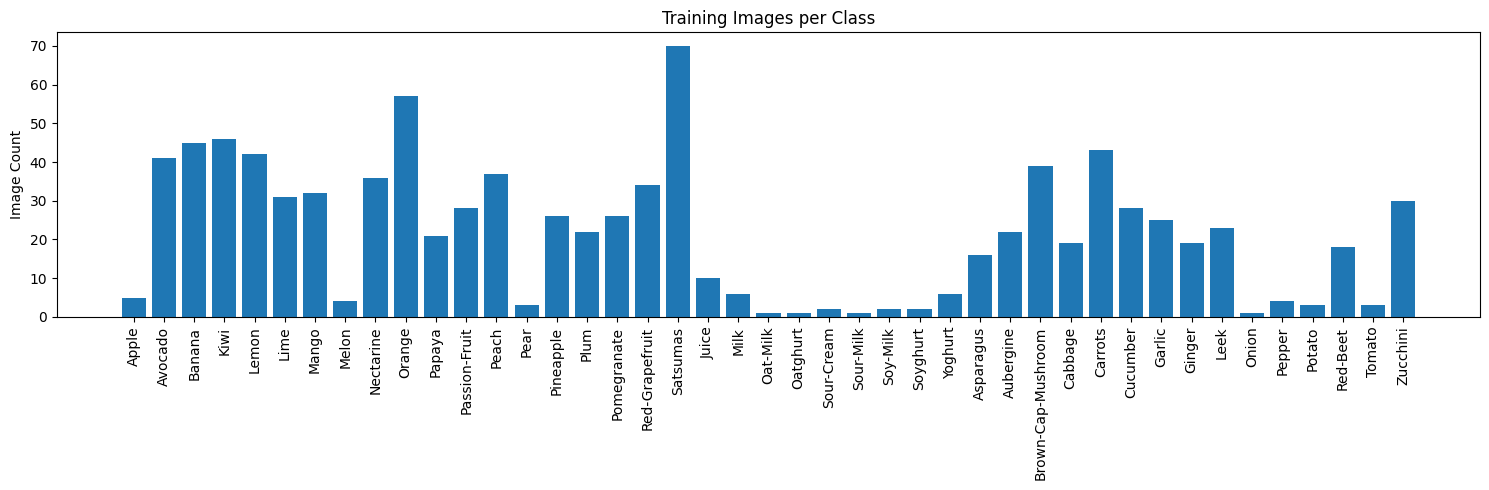

In [42]:
import matplotlib.pyplot as plt
from collections import Counter
import os

train_counts = Counter()
train_folder = '/content/drive/MyDrive/archive_unzipped/GroceryStoreDataset/dataset/train'

for cls in os.listdir(train_folder):
    class_path = os.path.join(train_folder, cls)
    if os.path.isdir(class_path):
        train_counts[cls] = len(os.listdir(class_path))

plt.figure(figsize=(15, 5))
plt.bar(train_counts.keys(), train_counts.values())
plt.xticks(rotation=90)
plt.title("Training Images per Class")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()


In [44]:

# EXAMPLE ONLY - Replace these with actual model predictions
y_true = ['Mango', 'Banana', 'Papaya', 'Banana', 'Apple']
y_pred = ['Mango', 'Papaya', 'Papaya', 'Banana', 'Apple']

print(" Classification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred, labels=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


 Classification Report:
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00         1
      Banana       1.00      0.50      0.67         2
       Mango       1.00      1.00      1.00         1
      Papaya       0.50      1.00      0.67         1

    accuracy                           0.80         5
   macro avg       0.88      0.88      0.83         5
weighted avg       0.90      0.80      0.80         5



ValueError: At least one label specified must be in y_true

### Project:

1. Perform exploratory data analysis on the 'train' and 'test' datasets to calculate class imbalance (by comparing 'samples per class' across all the classes)
2. Print confusion matrix, precision, recall and f1-score
3. Show a grid of 6x4 images, with actual and predicted class for each of those


### Bonus Project:

1. Allow user to input the items they shopped using images, use model to identify grocery item based on confidence threshold. If confidence is low, ask user to manually input the item.
2. Update the digital grocery cart
3. Process the transaction by generating a transaction receipt
